In [1]:
import torch
from transformers import pipeline
device = "cuda:0" if torch.cuda.is_available() else "cpu"

/mnt/c/Users/hakim/python/datascience/localllm/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Whisper model

- Developed by OpenAI, is a state-of-the-art automatic speech recognition (ASR) model. It's designed to convert spoken language into written text, excelling in transcribing and recognizing speech across multiple languages and dialects.


In [2]:
# create a pipeline of automated speach recognision
pipe = pipeline("automatic-speech-recognition", model="openai/whisper-base", device=device)

In [3]:
# Access the model from the pipeline
model = pipe.model
# Initialize total parameter counter
total_params = 0
# Loop through model parameters and calculate the total number
for name, param in model.named_parameters():
    total_params += param.numel() # Count the number of elements (parameters)

print(f"Total number of parameters in the model is: {total_params}")

Total number of parameters in the model is: 72593920


### General overview of Model

- Audio data is first converted into a log-Mel spectrogram, a common representation used in audio processing. A Mel spectrogram is a time-frequency representation of the audio signal, which compresses the frequency information in a way that mimics human auditory perception.

- Transformer Encoder-Decoder Architecture. In a sequence-to-sequence manner, the decoder predicts the text tokens step by step. It also incorporates language modeling, meaning it can "understand" context and generate coherent sentences.

- The decoder starts with an initial token and generates one token at a time. It uses previously predicted tokens (or special start tokens) as input for the next token prediction, leveraging autoregressive decoding. This means that the model generates the text word-by-word or character-by-character until it predicts a special end token.


### Load some Audio's

- https://huggingface.co/datasets/facebook/voxpopuli VoxPopuli is a large-scale multilingual speech corpus for representation learning, semi-supervised learning and interpretation. The raw data is collected from 2009-2020 European Parliament event recordings. We acknowledge the European Parliament for creating and sharing these materials. This implementation contains transcribed speech data for 18 languages. It also contains 29 hours of transcribed speech data of non-native English intended for research in ASR for accented speech (15 L2 accents)


In [4]:
from datasets import load_dataset
dataset_english = load_dataset("facebook/voxpopuli",
                               "en", # English language
                               split="validation",
                               trust_remote_code=True,
                               streaming=True
) # dataset is loaded lazily, instead of downloading the entire dataset at once
print(dataset_english)

IterableDataset({
    features: ['audio_id', 'language', 'audio', 'raw_text', 'normalized_text', 'gender', 'speaker_id', 'is_gold_transcript', 'accent'],
    n_shards: 1
})


In [6]:
# Create an iterator to stream the dataset
dataset_iter = iter(dataset_english)
# Process the first 3 samples
for i in range(3):
    # Get the next sample
    sample = next(dataset_iter)
    # Process each sample
    audio_data = sample['audio']
    transcription = sample.get("raw_text", "No transcription available")
    # Print the audio path and transcription
    print(f"Sample {i + 1}:")
    print(f"Audio: {audio_data['path']}")
    print(f"Transcription: {transcription}")
    print("-" * 50)




Sample 1:
Audio: dev_part_0/20160526-0900-PLENARY-3-en_20160526-10:18:50_2.wav
Transcription: Many measures have been taken, not only in September but also in March, and of course we see some effects of those measures perhaps not enough, but there are effects of those measures, and the situation could have been worse if we did not have taken those measures.
--------------------------------------------------
Sample 2:
Audio: dev_part_0/20170516-0900-PLENARY-21-en_20170516-22:11:57_24.wav
Transcription: We must be cautious with creating new rules because much is still unclear about future developments of financial technologies.
--------------------------------------------------
Sample 3:
Audio: dev_part_0/20180531-0900-PLENARY-15-en_20180531-15:00:20_3.wav
Transcription: Through its external financial instruments and the European Development Fund, the EU provides billions of euros in assistance to third countries through international organisations among other channels.
-----------------

# Listen to the Audio

In [9]:
from IPython.display import Audio
# Create an iterator to stream the dataset
database_iter = iter(dataset_english)

sample = next(database_iter)
Audio(sample["audio"]["array"], rate=sample["audio"]["sampling_rate"])

# Plot this Audio Waveform

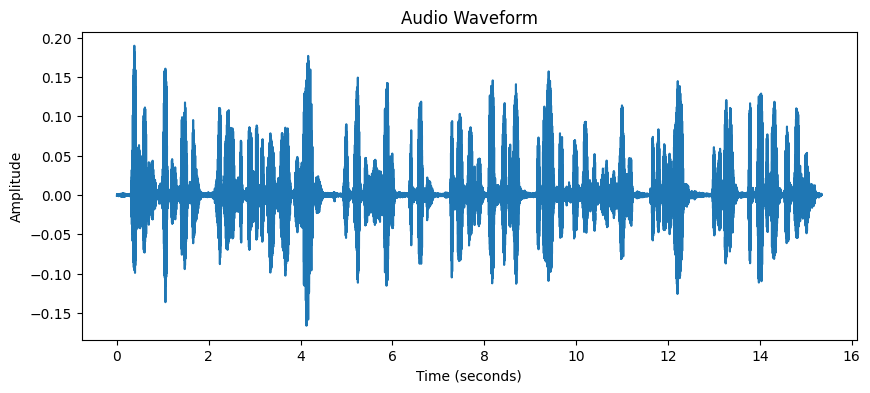

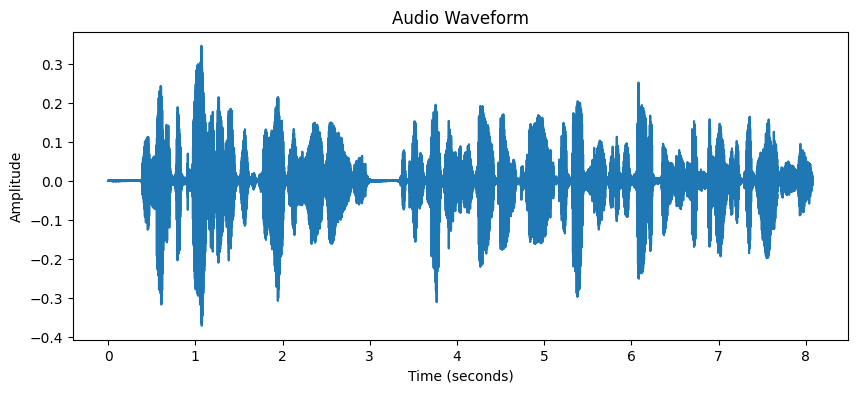

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def plot_waveform(audio_array, sampling_rate):
    plt.figure(figsize=(10, 4))
    plt.plot(np.linspace(0, len(audio_array) / sampling_rate, len(audio_array)), audio_array)
    plt.title("Audio Waveform")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.show()

# Create an iterator to stream the dataset
dataset_iter = iter(dataset_english)

sample = next(dataset_iter)
plot_waveform(sample["audio"]["array"], sample["audio"]["sampling_rate"])

sample = next(dataset_iter)
plot_waveform(sample["audio"]["array"], sample["audio"]["sampling_rate"])

# Let us do Audio to Text Translation

In [11]:
#!pip install jiwer


### What is Word Error Rate (WER)?

Word Error Rate (WER) is a metric that helps us measure the accuracy of a speech-to-text model. It compares the model’s transcription with the correct transcription (known as the ground truth). The WER calculates how many mistakes the model made, and it looks at three types of errors:
- **Substitutions (S)**: When the model replaces a correct word with a wrong one.
- **Deletions (D)**: When the model misses a word from the ground truth.
- **Insertions (I)**: When the model adds extra words that shouldn't be there.

The formula for WER is:

$\text{WER} = \frac{S + D + I}{N}$

Where **N** is the total number of words in the ground truth. The lower the WER, the better the model is at accurately transcribing speech.

For example, if the correct sentence is "The quick brown fox jumps over the lazy dog" and the model predicts "The quick brown jumps over lazy dog", there are:
- 1 Substitution (missed "fox"),
- 1 Deletion (missed "the"), and
- 0 Insertions.

If the correct transcription has 9 words, the WER would be:

\[
\frac{1 (\text{Substitution}) + 1 (\text{Deletion}) + 0 (\text{Insertion})}{9} = \frac{2}{9} \approx 0.22
\]

This means the model’s Word Error Rate is 22%, meaning 22% of the words were either wrong, missed, or extra.


In [12]:
from jiwer import wer

def translate(audio):
    outputs = pipe(audio, max_new_tokens=256, generate_kwargs={"task": "translate"})
    return outputs["text"]

def compare_transcriptions(whisper_transcription, ground_truth):
    print("Whisper Transcription:", whisper_transcription)
    print("Ground -------- Truth:", ground_truth)
    error_rate = wer(ground_truth, whisper_transcription)
    print(f"Word Error Rate: {error_rate:.2f}")

# Create an iterator to stream the dataset
dataset_iter = iter(dataset_english)

sample = next(dataset_iter)
whisper_transcription = translate(sample["audio"].copy())
ground_truth = sample.get("raw_text", "No transcription available")
compare_transcriptions(whisper_transcription, ground_truth)

/mnt/c/Users/hakim/python/datascience/localllm/env/lib/python3.12/site-packages/transformers/models/whisper/generation_whisper.py:496: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
You have passed task=translate, but also have set `forced_decoder_ids` to [[1, None], [2, 50359]] which creates a conflict. `forced_decoder_ids` will be ignored in favor of task=translate.
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.43.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Whisper Transcription:  Many measures have been taken not only in September but also in March. And of course we see some effects of those measures, perhaps not enough, but there are effects of those measures. And the situation could have been worse if we didn't have taken those measures.
Ground -------- Truth: Many measures have been taken, not only in September but also in March, and of course we see some effects of those measures perhaps not enough, but there are effects of those measures, and the situation could have been worse if we did not have taken those measures.
Word Error Rate: 0.17


In [13]:
# the second sample from the dataset
sample = next(dataset_iter)
whisper_transcription = translate(sample["audio"].copy())
ground_truth = sample.get("raw_text", "No transcription available")
compare_transcriptions(whisper_transcription, ground_truth)

Whisper Transcription:  We must be cautious with creating new rules, because much is still unclear about future developments of financial technologies.
Ground -------- Truth: We must be cautious with creating new rules because much is still unclear about future developments of financial technologies.
Word Error Rate: 0.05


In [14]:
sample = next(dataset_iter)
whisper_transcription = translate(sample["audio"].copy())
ground_truth = sample.get("raw_text", "No transcription available")
compare_transcriptions(whisper_transcription, ground_truth)

Whisper Transcription:  Through its external financial instruments and the European Development Fund, the EU provides billions of euros in assistance to third countries, through international organizations among other channels.
Ground -------- Truth: Through its external financial instruments and the European Development Fund, the EU provides billions of euros in assistance to third countries through international organisations among other channels.
Word Error Rate: 0.07
